# 词嵌入：编码形式的词汇语义
  
  
词嵌入(word embedding)是一种由真实数字组成的稠密向量，每个向量都代表了单词表里的一个单词。用one-hot encoding表示单词，单词可以表示为：  
$$\hat y_{i}\in T$$  
其中，1表示的独有位置，其他位置全是0。其他的词都类似，在另外不一样的位置有一个1代表 它，其他位置也都是0。这种表达除了占用巨大的空间外，还有个很大的缺陷。它只是简单的把词看做一个单独个体，认为它们之间毫无联系。我们真正想要的是能够表达单词之间一些相似的含义。  
相似性理念：指的是语义相似，而不是简单的拼写相似。这就是一种通过连接我们发现的和没发现的一些内容相似点、用于解决语言数据稀疏性的技术。这个例子依赖于一个基本的语言假设：那些在 相似语句中出现的单词，在语义上也是相互关联的。这就叫做**distributional hypothesis（分布式假设）**。


讲解：Tutorial P205

## 密集词嵌入(Getting Dense Word Embedding)

与制作 one-hot 向量时对每个单词定义一个特殊的索引类似，当我们使用词向量时也需要为每个单词定义一个索引。这些索引将是查询表的关键点。意思就是，词嵌入被被存储在一个$|V|\times D$的向量中，其中$D$是词嵌入的维度。词被被分配的索引i，表示在向量的第i行存储它的嵌入。在所有的代码中，从单词到索引的映射是一个叫word_to_ix的字典。

能使用词嵌入的模块是torch.nn.Embedding，这里面有两个参数：词汇表的大小和词嵌入的维度。  
索引这张表时，必须使用torch.LongTensor（因为索引是整数，不是浮点数）。


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
# 在神经网络中，参数默认是进行随机初始化的。
# 不同的初始化参数往往会导致不同的结果，当
# 得到比较好的结果时我们通常希望这个结果是
# 可以复现的，在pytorch中，通过设置随机数种
# 子可以达到这个目的。

In [9]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)
# 2 words in vocab, 5 dimensional embeddings 

lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype = torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

lookup_tensor = torch.tensor([word_to_ix["world"]], dtype = torch.long)
world_embed = embeds(lookup_tensor)
print(world_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]],
       grad_fn=<EmbeddingBackward>)
tensor([[-0.1661, -1.5228,  0.3817, -1.0276, -0.5631]],
       grad_fn=<EmbeddingBackward>)


## N-Gram语言模型

在本例中，我们将在训练样例上计算损失函数，并且用反向传播算法更新参数。

In [10]:
CONTENT_SIZE = 2
EMBEDDING_DIM = 10

test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split() 

# 创建一系列的元组，每个元组都是([ word_i-2, word_i-1 ], target word)的形式。
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[1 + 2]) 
            for i in range(len(test_sentence) - 2)]
print(trigrams[:3])

[(['When', 'forty'], 'shall'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'shall')]


In [11]:
vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [13]:
vocab

{"'This",
 'And',
 'How',
 'If',
 'Proving',
 'Shall',
 'Then',
 'This',
 'Thy',
 'To',
 'Were',
 'When',
 'Where',
 'Will',
 'a',
 'all',
 'all-eating',
 'an',
 'and',
 'answer',
 'art',
 'asked,',
 'be',
 'beauty',
 "beauty's",
 'being',
 'besiege',
 'blood',
 'brow,',
 'by',
 'child',
 'cold.',
 'couldst',
 'count,',
 'days;',
 'deep',
 "deserv'd",
 'dig',
 "excuse,'",
 'eyes,',
 'fair',
 "feel'st",
 'field,',
 'forty',
 'gazed',
 'held:',
 'his',
 'in',
 'it',
 'lies,',
 'livery',
 'lusty',
 'made',
 'make',
 'mine',
 'more',
 'much',
 'my',
 'new',
 'now,',
 'of',
 'old',
 'old,',
 'on',
 'own',
 'praise',
 'praise.',
 'proud',
 'say,',
 'see',
 'shall',
 'shame,',
 'small',
 'so',
 'succession',
 'sum',
 'sunken',
 'the',
 'thine',
 'thine!',
 'thou',
 'thriftless',
 'thy',
 'to',
 "totter'd",
 'treasure',
 'trenches',
 'use,',
 'warm',
 'weed',
 'were',
 'when',
 'where',
 'winters',
 'within',
 'worth',
 "youth's"}

In [14]:
word_to_ix

{'new': 0,
 'treasure': 1,
 'and': 2,
 'answer': 3,
 'the': 4,
 'eyes,': 5,
 'his': 6,
 'couldst': 7,
 'Where': 8,
 'livery': 9,
 "'This": 10,
 'see': 11,
 'so': 12,
 'gazed': 13,
 'a': 14,
 'When': 15,
 'more': 16,
 'dig': 17,
 'cold.': 18,
 'sunken': 19,
 'lusty': 20,
 'an': 21,
 'Shall': 22,
 'on': 23,
 'to': 24,
 'held:': 25,
 "deserv'd": 26,
 'old': 27,
 'Proving': 28,
 'now,': 29,
 'where': 30,
 'thou': 31,
 'when': 32,
 'Thy': 33,
 'make': 34,
 'old,': 35,
 'beauty': 36,
 'succession': 37,
 'Then': 38,
 'being': 39,
 "beauty's": 40,
 'thine': 41,
 'praise': 42,
 'own': 43,
 'shame,': 44,
 'in': 45,
 'of': 46,
 'blood': 47,
 'thine!': 48,
 'sum': 49,
 'small': 50,
 'praise.': 51,
 'mine': 52,
 'Were': 53,
 'lies,': 54,
 'all': 55,
 'were': 56,
 'child': 57,
 'worth': 58,
 'say,': 59,
 'asked,': 60,
 'thy': 61,
 'use,': 62,
 'warm': 63,
 'To': 64,
 'it': 65,
 'all-eating': 66,
 "totter'd": 67,
 'art': 68,
 'proud': 69,
 'much': 70,
 'Will': 71,
 'winters': 72,
 "excuse,'": 73,
 'I

In [15]:
class NGramLanguageModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim = 1)
        return log_probs

In [16]:
losses = []
loss_array = []
loss_func = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTENT_SIZE)
optimizer = optim.SGD(model.parameters(), lr = 0.001)

In [17]:
import numpy as np

In [18]:
for epoch in range(10):
    total_loss = 0
    for context, target in trigrams:
        # 步骤 1\. 准备好进入模型的数据 (将单词转换成整数索引,并将其封装在变量中) 
        context_idxs = torch.tensor([word_to_ix[w] for w in context], 
                                    dtype = torch.long)
        model.zero_grad()
        log_probs = model(context_idxs)
        if epoch == 9:
            loss_array.append(log_probs.detach().numpy().tolist())
        
        loss = loss_func(log_probs, torch.tensor([word_to_ix[target]],
                                                 dtype = torch.long))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)

[472.0449995994568, 357.17093300819397, 251.49774289131165, 166.4249681085348, 108.98749705404043, 74.22339110076427, 53.39227048121393, 40.37298555485904, 31.793557859491557, 25.85718860803172]


In [19]:
loss_array

[[[-6.730871677398682,
   -7.148969650268555,
   -6.8173089027404785,
   -6.456246852874756,
   -6.941878795623779,
   -7.087700366973877,
   -6.971417427062988,
   -6.635455131530762,
   -6.532652854919434,
   -6.720569610595703,
   -6.267275333404541,
   -7.027429580688477,
   -6.930427551269531,
   -6.38394832611084,
   -7.124406337738037,
   -6.63812255859375,
   -6.544094085693359,
   -7.031150817871094,
   -6.840510368347168,
   -6.956733703613281,
   -6.756511211395264,
   -6.510631084442139,
   -6.636354446411133,
   -7.0991435050964355,
   -6.568653583526611,
   -6.571506977081299,
   -6.892112731933594,
   -6.772452354431152,
   -6.926939487457275,
   -7.056480884552002,
   -6.85699462890625,
   -7.1766791343688965,
   -6.8917765617370605,
   -6.927713871002197,
   -7.411821365356445,
   -6.903303623199463,
   -6.891373634338379,
   -6.751880168914795,
   -6.503616809844971,
   -7.007416725158691,
   -6.908706188201904,
   -6.924942493438721,
   -6.894096374511719,
   -6.3960

In [20]:
np.shape(loss_array)

(113, 1, 97)

In [21]:
nploss = np.array(loss_array)

In [22]:
nploss

array([[[-6.73087168, -7.14896965, -6.8173089 , ..., -6.73324108,
         -6.93062687, -7.01631641]],

       [[-7.12542248, -7.51482391, -6.73815918, ..., -7.38992786,
         -7.58487415, -7.11667728]],

       [[-5.45325089, -5.71074677, -5.10074472, ..., -5.22510672,
         -5.85025501, -5.49083757]],

       ...,

       [[-6.35166454, -7.19569874, -6.61981106, ..., -6.46780825,
         -6.72623253, -6.86006641]],

       [[-5.81318521, -5.78566742, -5.8080349 , ..., -5.56491613,
         -5.68753338, -5.82714653]],

       [[-5.72435856, -5.92670727, -5.40377998, ..., -5.26590729,
         -5.85236359, -5.42726517]]])

In [23]:
nploss.reshape(-1).reshape(-1, 97)

array([[-6.73087168, -7.14896965, -6.8173089 , ..., -6.73324108,
        -6.93062687, -7.01631641],
       [-7.12542248, -7.51482391, -6.73815918, ..., -7.38992786,
        -7.58487415, -7.11667728],
       [-5.45325089, -5.71074677, -5.10074472, ..., -5.22510672,
        -5.85025501, -5.49083757],
       ...,
       [-6.35166454, -7.19569874, -6.61981106, ..., -6.46780825,
        -6.72623253, -6.86006641],
       [-5.81318521, -5.78566742, -5.8080349 , ..., -5.56491613,
        -5.68753338, -5.82714653],
       [-5.72435856, -5.92670727, -5.40377998, ..., -5.26590729,
        -5.85236359, -5.42726517]])

In [24]:
np.shape(nploss)

(113, 1, 97)

In [34]:
nploss = np.reshape(nploss,(-1,97))

In [35]:
np.shape(nploss)

(113, 97)

In [36]:
nploss

array([[-6.73087168, -7.14896965, -6.8173089 , ..., -6.73324108,
        -6.93062687, -7.01631641],
       [-7.12542248, -7.51482391, -6.73815918, ..., -7.38992786,
        -7.58487415, -7.11667728],
       [-5.45325089, -5.71074677, -5.10074472, ..., -5.22510672,
        -5.85025501, -5.49083757],
       ...,
       [-6.35166454, -7.19569874, -6.61981106, ..., -6.46780825,
        -6.72623253, -6.86006641],
       [-5.81318521, -5.78566742, -5.8080349 , ..., -5.56491613,
        -5.68753338, -5.82714653],
       [-5.72435856, -5.92670727, -5.40377998, ..., -5.26590729,
        -5.85236359, -5.42726517]])

In [30]:
loss_array = nploss.tolist()

In [31]:
loss_array

[[[-6.730871677398682],
  [-7.148969650268555],
  [-6.8173089027404785],
  [-6.456246852874756],
  [-6.941878795623779],
  [-7.087700366973877],
  [-6.971417427062988],
  [-6.635455131530762],
  [-6.532652854919434],
  [-6.720569610595703],
  [-6.267275333404541],
  [-7.027429580688477],
  [-6.930427551269531],
  [-6.38394832611084],
  [-7.124406337738037],
  [-6.63812255859375],
  [-6.544094085693359],
  [-7.031150817871094],
  [-6.840510368347168],
  [-6.956733703613281],
  [-6.756511211395264],
  [-6.510631084442139],
  [-6.636354446411133],
  [-7.0991435050964355],
  [-6.568653583526611],
  [-6.571506977081299],
  [-6.892112731933594],
  [-6.772452354431152],
  [-6.926939487457275],
  [-7.056480884552002],
  [-6.85699462890625],
  [-7.1766791343688965],
  [-6.8917765617370605],
  [-6.927713871002197],
  [-7.411821365356445],
  [-6.903303623199463],
  [-6.891373634338379],
  [-6.751880168914795],
  [-6.503616809844971],
  [-7.007416725158691],
  [-6.908706188201904],
  [-6.924942493

In [32]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

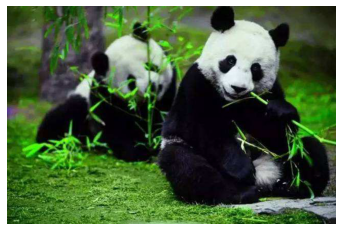

In [6]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
 
lena = mpimg.imread('panda.jpg') # 读取和代码处于同一目录下的 lena.png
# 此时 lena 就已经是一个 np.array 了，可以对它进行任意处理
lena.shape #(512, 512, 3)
 
plt.imshow(lena) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

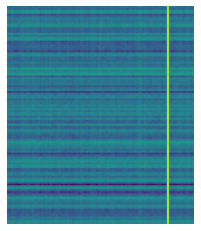

In [37]:
plt.imshow(nploss) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()